In [149]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, re
from collections import Counter

def batch_convert_folder(folder_path, extension=".txt", mute = False):
    """
    Converts all .dat files in a folder to .txt step profiles.
    Saves outputs next to input files.
    Parameters:
        folder_path (str): Path to directory with .dat files
        extension (str): Output extension
    """
    files = []
    for root, _, filenames in os.walk(folder_path):
        for f in filenames:
            if f.endswith(".dat"):
                files.append(os.path.join(root, f))
    data = {}
    for file_path in files:
        fname = os.path.basename(file_path)
        z = convert_dat(file_path, extension, mute)
        data.update({file_path:z})
    return data

def batch_convert_file(file, extension=".txt", mute = False):
    """
    Converts .dat file(s) to .txt step profiles.
    Saves outputs next to input files.
    Parameters:
        file (str/list): Path to directory with .dat file
        extension (str): Output extension
    """
    if isinstance(file,list):
        files = file
    else:
        files = [file]
    data = {}
    for file_path in files:
        fname = os.path.basename(file_path)
        z = convert_dat(file_path, extension, mute)
        data.update({file_path:z})
    return data   

def convert_dat(file_path, extension=".txt", mute = False):
    try:
        z = P7_dat2Z(file_path)
        folder_path = os.path.dirname(file_path)
        fname = os.path.basename(file_path)
        output_name = os.path.splitext(fname)[0] + extension
        out_path = os.path.join(folder_path, output_name)
        data = np.column_stack((np.arange(len(z)),z))
        np.savetxt(out_path, data, fmt="%.3f",delimiter='\t\t\t',header="Points\t\t\tZ (nm)\t\t\t")
        if not mute:
            print(f"Saved: {output_name}")
        return np.array(z)
    except Exception as e:
        print(f"Failed on {file_path}: {e}")


def decode_fixed_point(int_part, frac_part):
    # frac_part is signed int16 → convert to unsigned uint16 interpretation
    frac_unsigned = frac_part.astype('uint16')
    return int_part + frac_unsigned / 65536.0

def auto_detect_data_block_after_zeros(data, zero_run=2000, jump_thresh=10000):
    last_zero_index = None
    for i in range(len(data) - zero_run):
        if np.all(data[i:i + zero_run] == 0):
            last_zero_index = i
    if last_zero_index is None:
        return None, None

    start_scan = last_zero_index + zero_run
    end = None

    for j in range(start_scan, len(data), 2):
        segment = data[j:]
        z_int = segment[1::2]
        dz = np.diff(z_int)
        jumps = np.where(np.abs(dz) > jump_thresh)[0]
        if len(jumps) > 0:
            end = j + 2 * (jumps[0] + 1)
            break

    return start_scan, end

def infer_scale_from_recipe(raw):
    """Extract KLA P-7 .dat binary file to extract recipe and scaling factor accordingly.
    Parameters:
        raw binary file 
    Returns:
        Scaling factor regarding different measurement range:
        13um/0.0078A range:     x6.4
        131um/0.0781A:          x102.4
        1048um/0.6250A:         x6.4 
    """
    if b'Z_13UM' in raw:
        return 64/10
    elif b'Z_131UM' in raw:
        return 1024/10
    elif b'Z_1048UM' in raw:
        return 64/10
    else:
        print('Unknown recipe, please scale your data with\n        x6.4 for 13um/0.0078A range\n       x102.4 for 131um/0.0781A\n       x6.4 for 1048um/0.6250A\n')
        return 1

def infer_scale_from_high_byte(z_int, verbose=False):
    """
    Infers the vertical scale factor from the high byte of int16 values.

    Parameters:
        z_int (np.ndarray): Array of int16 integers (Z_int part of the Z data)
        verbose (bool): Whether to print diagnostic messages

    Returns:
        scale (float): Suggested scaling factor, or None if unknown
    """
    # Extract high bytes (unsigned)
    high_bytes = ((z_int.astype(np.int16) >> 8) & 0xFF)

    # Check for uniformity
    unique_bytes = np.unique(high_bytes)
    if verbose:
        if len(unique_bytes) == 1:
            print(f"[✓] All high bytes are 0x{unique_bytes[0]:02X}")
        else:
            print(f"[!] Multiple high bytes detected: {[f'0x{x:02X}' for x in unique_bytes]}")

    # Scale mapping (you can extend this)
    scale_lookup = {
        0xC5: 32 / 10,
        0xC6: 64 / 10,    
        0xC8: 1024 / 10,
    }
    counter = Counter(high_bytes)
    most_common, count = counter.most_common(1)[0]
    scale_byte = most_common
    scale = scale_lookup.get(scale_byte, None)
    if verbose:
        if scale:
            print(f"[✓] Assigned scale = {scale}")
        else:
            print(f"[?] No known scale for high byte 0x{scale_byte:02X}")
    return scale
        
def P7_dat2Z(file_path):
    """Decode KLA P-7 .dat binary file to extract Z arrays.
    Parameters:
        file_path (str): Path to .dat file
    Returns:
        z (np.ndarray): Z heights (Å)
    Assume:
        frac-int format
    """
    with open(file_path, "rb") as f:
        raw = f.read()
    data = np.frombuffer(raw, dtype='<i2')
    # print(raw)
    start, end = auto_detect_data_block_after_zeros(data)
    # print(start,end)
    block = data[start:end]
    z_int = block[1::2]
    z_frac = block[0::2]
    min_len = min(len(z_int),len(z_frac))
    z = decode_fixed_point(z_int[:min_len], z_frac[:min_len])
    # scale = scale_from_recipe(raw)
    scale = infer_scale_from_high_byte(z_int)
    return -np.array(z-z[0])*scale


In [150]:
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

class StepProfile:
    def __init__(self, z, sigma=5, threshold=0.5, ForceOneStep = False):
        z = z [int(len(z)/5):-int(len(z)/5)]
        self.z = np.asarray(z)
        self.x = np.arange(len(self.z))

        # Smoothing and gradient
        self.z_smooth = gaussian_filter1d(self.z, sigma=sigma)
        dzdx = np.gradient(self.z_smooth, self.x[1] - self.x[0])

        # Detect rising and falling edges
        self.rise_peaks, _ = find_peaks(dzdx, prominence=threshold * np.max(np.abs(dzdx)))
        self.fall_peaks, _ = find_peaks(-dzdx, prominence=threshold * np.max(np.abs(dzdx)))

        # Pair edges
        self.edges = []
        if len(self.rise_peaks) == 0 and len(self.fall_peaks) == 0:
            raise ValueError("Auto-segmentation failed.")
        elif len(self.rise_peaks) == 0 and not ForceOneStep:
            self.edges.append((self.x[0], self.fall_peaks[0])) # High-Low profile
        else:
            for r in self.rise_peaks:
                f_candidates = self.fall_peaks[self.fall_peaks > r]
                if len(f_candidates) == 0 and not ForceOneStep:
                    self.edges.append((r, self.x[-1])) # Low-High profile
                    break
                if ForceOneStep:
                    f = f_candidates[-1]
                    self.edges.append((r, f))
                    break
                else:
                    f = f_candidates[0]
                    self.edges.append((r, f))

        # Global leveling using out-of-edge regions
        mask = np.zeros_like(self.z, dtype=bool)
        for r, f in self.edges:
            mask[r-sigma:f+sigma] = True
        self.x_fit = self.x[~mask]
        self.z_fit_input = self.z[~mask]
        # --- Split into left and right of step ---
        if len(self.edges) > 0:
            r, f = self.edges[0]  # assuming one main step
            left_mask = self.x_fit < r
            right_mask = self.x_fit > f

            z_fit_combined = np.zeros_like(self.z, dtype=float)

            # Fit left side independently
            if np.sum(left_mask) > 2:
                coeffs_left = np.polyfit(self.x_fit[left_mask], self.z_fit_input[left_mask], 1)
                z_fit_combined[self.x < r] = np.polyval(coeffs_left, self.x[self.x < r])

            # Fit right side independently
            if np.sum(right_mask) > 2:
                coeffs_right = np.polyfit(self.x_fit[right_mask], self.z_fit_input[right_mask], 1)
                z_fit_combined[self.x > f] = np.polyval(coeffs_right, self.x[self.x > f])

            # Fill masked step region with linear interpolation between ends
            if np.sum(left_mask) > 0 and np.sum(right_mask) > 0:
                left_end_val = np.polyval(coeffs_left, r)
                right_start_val = np.polyval(coeffs_right, f)
                interp_x = np.arange(r, f+1)
                interp_y = np.linspace(left_end_val, right_start_val, len(interp_x))
                z_fit_combined[r:f+1] = interp_y

            self.z_fit = z_fit_combined
        else:
            # Fallback: single fit
            coeffs = np.polyfit(self.x_fit, self.z_fit_input, 1)
            self.z_fit = np.polyval(coeffs, self.x)

        # Subtract leveling
        self.z_flat = self.z - self.z_fit

        # Smoothed leveled data
        self.z_smooth = gaussian_filter1d(self.z_flat, sigma=sigma)

        # Compute height and region means
        self.region_means = []
        self.heights = []
        for r, f in self.edges:
            left = self.z_flat[max(0, r - 2 * sigma):r]
            middle = self.z_flat[r:f]
            right = self.z_flat[f:min(len(self.z), f + 2 * sigma)]
            if len(left) > 0 and len(middle) > 0:
                low = np.mean(left)
                high = np.mean(middle)
            elif len(right) > 0 and len(middle) > 0:
                low = np.mean(right)
                high = np.mean(middle)
            self.region_means.append((r, f, low, high))
            self.heights.append(high - low)

        # ISO 25178 parameters
        self.height = float(np.mean(self.heights)) if self.heights else None
        self.sa = float(np.mean(np.abs(self.z_flat - np.mean(self.z_flat))))
        self.sz = float(np.max(self.z_flat) - np.min(self.z_flat))
        self.sq = float(np.sqrt(np.mean((self.z_flat - np.mean(self.z_flat))**2)))
        
    def plot(self, save=False):
        fg = plt.figure(figsize=(10, 4))
        plt.plot(self.x, self.z, label='Raw')
        plt.plot(self.x, self.z_fit,'--', label='Fitted')
        plt.plot(self.x, self.z_flat, label='Leveled')
        plt.plot(self.x, self.z_smooth, label='Smoothed')
        plt.scatter(self.x[self.rise_peaks], self.z_flat[self.rise_peaks], c='g', label='Rising')
        plt.scatter(self.x[self.fall_peaks], self.z_flat[self.fall_peaks], c='r', label='Falling')
        for r, f, low, high in self.region_means:
            plt.fill_between(self.x, low, high, where=(self.x > r) & (self.x < f), color='orange', alpha=0.2)
        plt.title(f"Step Height: {self.height:.2f} nm | Sa: {self.sa:.2f} nm | Sz: {self.sz:.2f} nm | Sq: {self.sq:.2f} nm")
        plt.xlabel("Position")
        plt.ylabel("Height (nm)")
        plt.legend()
        plt.tight_layout()
        if not save:
            plt.show()
        else:
            return fg

In [151]:
from scipy.signal import savgol_filter
from scipy.stats import linregress
def uniformity_corr(folder_path, plot=False, sigma=10, threshold=0.5, extension=".txt", mute=True, ForceOneStep=True, SavePlot=False):
    """
    Process all step profiles in LEFT, CENTER, RIGHT folders.
    Computes step height and roughness vs position.

    Returns:
        pd.DataFrame with columns: position, height, roughness
    """
    data_points = []

    region_info = {
        "LEFT":   np.linspace(-46, -8, 20),
        "CENTER": np.linspace(-6, 6, 7),
        "RIGHT":  np.linspace(8, 46, 20),
    }

    for region, positions in region_info.items():
        region_folder = os.path.join(folder_path, region)
        if not os.path.isdir(region_folder):
            print(f"Missing folder: {region_folder}")
            continue
        
        files = []
        for root, _, filenames in os.walk(region_folder):
            for f in filenames:
                if f.endswith(".dat"):
                    files.append(os.path.join(root, f))
        for file_path in files:
            try:
                fname = os.path.basename(file_path)
                index = int(re.findall(r"\d+", fname)[0]) - 1  # stepX → index 0-based
                pos = positions[index]
                z = convert_dat(file_path, extension=extension, mute=mute)
                profile = StepProfile(z, sigma=sigma, threshold=threshold, ForceOneStep = ForceOneStep) # Force One Step(low-high-low) for this calibration profile
                if SavePlot:
                    fg = profile.plot(save=True)
                    os.makedirs(os.path.join(folder_path,'fit'),exist_ok=True)
                    plt.savefig(os.path.join(folder_path,'fit',f"{int(pos)}.png"))
                    plt.close(fg)
                row = {"position": pos, "height": profile.height, "roughness": profile.sa}
                data_points.append(row)
            except Exception as e:
                print(f"Failed on {f} in {region}: {e}")

    df = pd.DataFrame(data_points)
    df = df.sort_values(by="position").reset_index(drop=True)
    slope, intercept, r_value, p_value, std_err = linregress(df["position"], df["height"])
    # Predicted values
    df["linearFit"] = slope * df["position"] + intercept
    df["smoothFit"] = savgol_filter(df["height"], window_length=11, polyorder=3)
    # Plot
    if plot:
        fg = plt.figure()
        plt.plot(df["position"], df["height"], 'o--', color='tab:blue', label="Step Height", mfc= 'None', mew=2)
        plt.fill_between(df["position"], df["height"]-df["roughness"], df["height"]+df["roughness"], color='tab:orange', alpha=0.2,label='Roughness')
        plt.plot(df["position"], df["smoothFit"],'g--', label = 'Smooth fit', alpha=0.5)
        plt.plot(df["position"], df["linearFit"],'r--', label = 'Linear fit', alpha=0.5)
        plt.xlabel("Position (µm)")
        plt.ylabel("Height (nm)")
        plt.title("Step Height Profile")
        # for position, height in zip(df["position"],df["height"]):
        #     plt.text(position,height,f'{int(position)}')
        plt.legend()
        plt.tight_layout()
        if not SavePlot:
            plt.show()
        else:
            plt.savefig(os.path.join(folder_path,'fit',f"Sum.png"))
            # plt.close(fg)
    return df

In [152]:
# Example 1: Batch convert .dat files to txt
#            a)   Method: Convert the whole folder
print("--Folder Convertion")
folder = r"C:\Users\xd255\OneDrive - Cornell University\CNF\Data\20250716_Unifomity_forCorr_45deg_5As_1000A\data"
folder_data = batch_convert_folder(folder)
#            b)   Method: Convert the idividual file
print("--Individual file Convertion")
file = r"C:\Users\xd255\OneDrive - Cornell University\CNF\Data\20250716_Unifomity_forCorr_45deg_5As_1000A\data\0mm.dat"
file_data = batch_convert_file(file)
#            c)   Method: Convert the list of files
print("--List of files Convertion")
files = [r"C:\Users\xd255\OneDrive - Cornell University\CNF\Data\20250716_Unifomity_forCorr_45deg_5As_1000A\data\0mm.dat",
         r"C:\Users\xd255\OneDrive - Cornell University\CNF\Data\20250716_Unifomity_forCorr_45deg_5As_1000A\data\2mm.dat"]
files_data = batch_convert_file(files)

--Folder Convertion
Saved: 0mm.txt
Saved: 0mm_SIMPLE.txt
Saved: 10mm.txt
Saved: 12mm.txt
Saved: 14mm.txt
Saved: 16mm.txt
Saved: 18mm.txt
Saved: 20mm.txt
Saved: 22mm.txt
Saved: 24mm.txt
Saved: 2mm.txt
Saved: 4mm.txt
Saved: 6mm.txt
Saved: 8mm.txt
--Individual file Convertion
Saved: 0mm.txt
--List of files Convertion
Saved: 0mm.txt
Saved: 2mm.txt


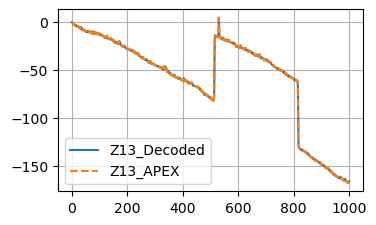

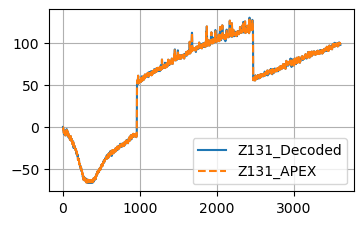

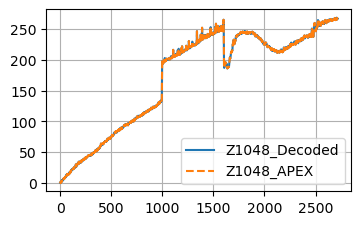

In [153]:
# Example 2: APEX .txt comparison from \ExampleFiles folder
example_folder_path = "ExampleFiles"
fname_list = ['Z13','Z131','Z1048']
for fname in fname_list:
    plt.figure(figsize=(10/2.54, 6/2.54))
    decoded = P7_dat2Z(os.path.join(example_folder_path,fname+'.dat'))
    apex_df = pd.read_csv(os.path.join(example_folder_path,fname+'_APEX.txt'), sep=r"\s+", header=None, names=["x", "z"])
    plt.plot(decoded, label=fname + "_Decoded")
    plt.plot(apex_df['z']-apex_df['z'][0], '--', label=fname + "_APEX")
    plt.legend()
    plt.grid()
    plt.show()


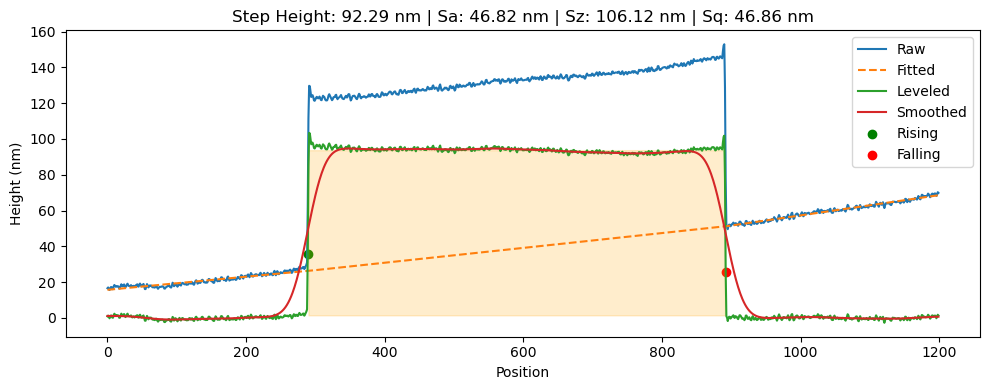

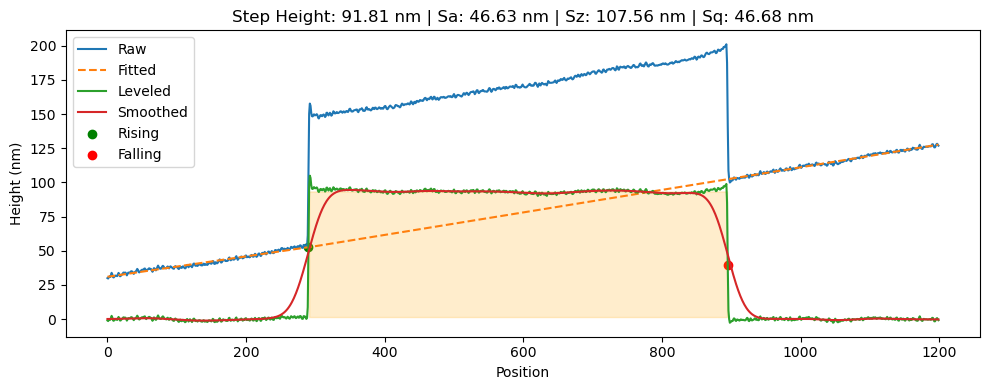

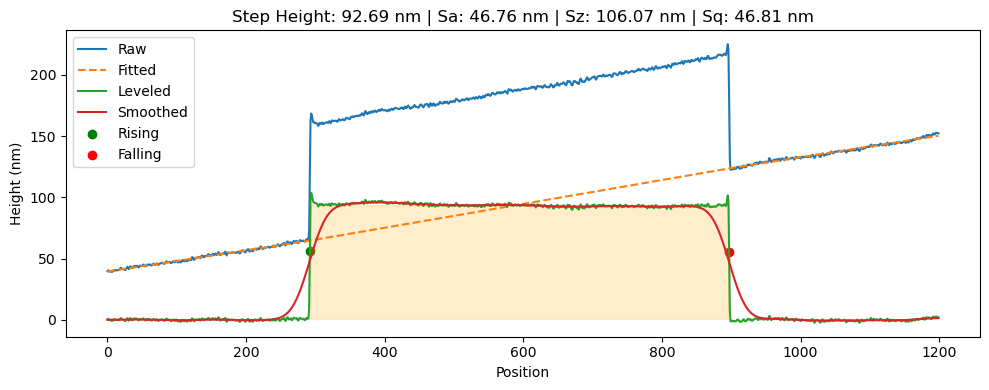

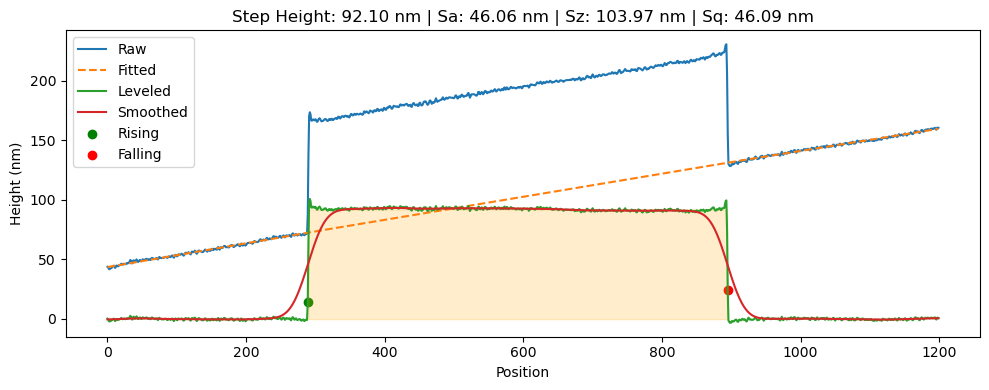

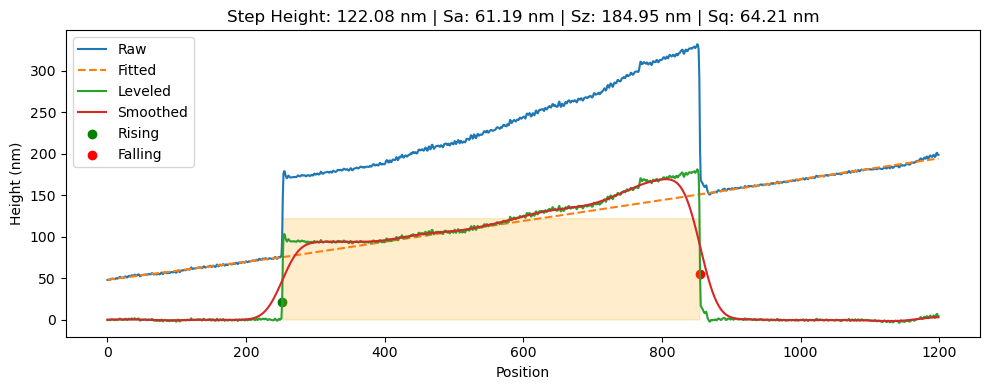

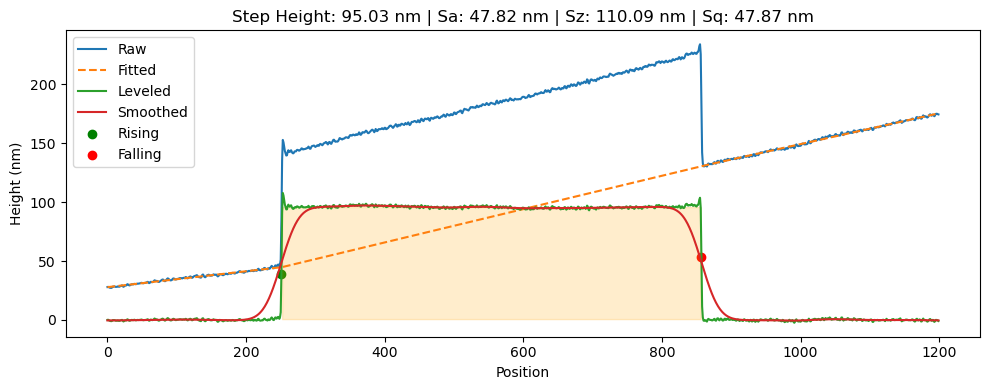

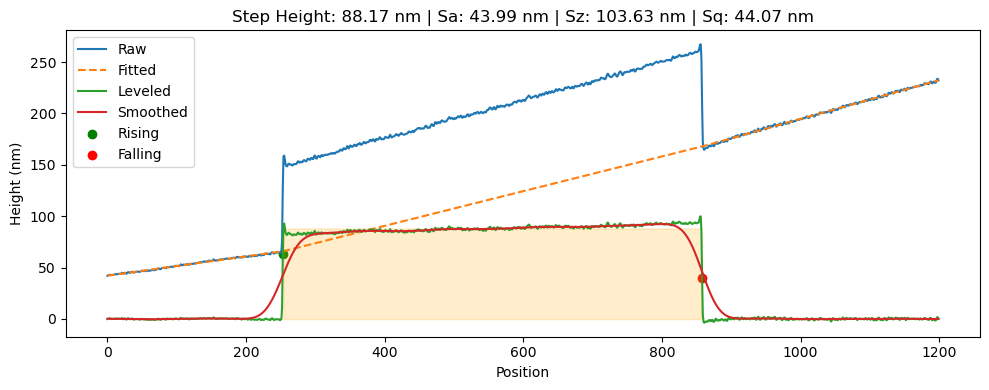

In [154]:
# Example 3: level the z and auto process step height
folder = r"C:\Users\xd255\OneDrive - Cornell University\CNF\Data\20250801_UniformityCorr_0deg5As1000A\CENTER"
folder_data = batch_convert_folder(folder, mute=True)
# - Plot for visualization
for key, value in folder_data.items():
    profile = StepProfile(value,sigma=20,threshold=0.4,ForceOneStep=True)
    profile.plot()

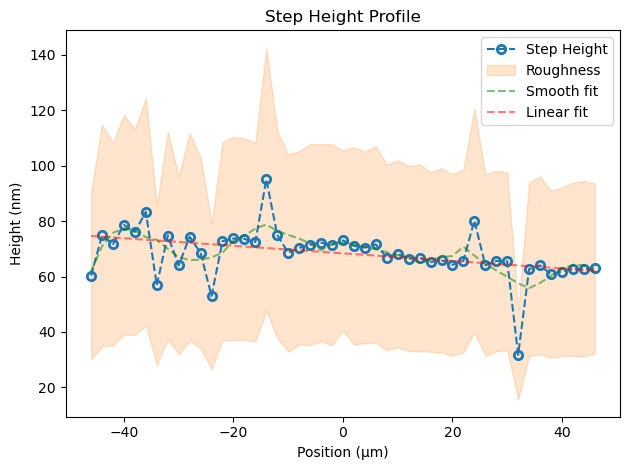

In [161]:
# folder_path = r"C:\Users\xd255\OneDrive - Cornell University\CNF\Data\20250728_UniformityCorr_45deg2As1000A"
# folder_path = r"C:\Users\xd255\OneDrive - Cornell University\CNF\Data\20250728_UniformityCorr_45deg3As1000A"
folder_path = r"C:\Users\xd255\OneDrive - Cornell University\CNF\Data\20250728_UniformityCorr_45deg5As1000A"
# folder_path = r"C:\Users\xd255\OneDrive - Cornell University\CNF\Data\20250801_UniformityCorr_0deg2As1000A"
# folder_path = r"C:\Users\xd255\OneDrive - Cornell University\CNF\Data\20250801_UniformityCorr_0deg3As1000A"
# folder_path = r"C:\Users\xd255\OneDrive - Cornell University\CNF\Data\20250801_UniformityCorr_0deg5As1000A"
df = uniformity_corr(folder_path, plot=True, sigma=20, threshold=0.4, ForceOneStep=True, SavePlot=True)
output_name = "step_heights.csv"
out_path = os.path.join(folder_path, output_name)
df.to_csv(out_path, index=False)